In [23]:
import os
import json
import re
from dotenv import load_dotenv
from typing import Dict, Any, List, Optional, Tuple, Annotated
from IPython.display import Image, display

from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END

In [ ]:
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>{{company_name}} - Official Website</title>
</head>
<body>
    <header>
        <h1>Welcome to {{company_name}}</h1>
        <p>{{company_tagline}}</p>
    </header>
    
    <section class="mission">
        <h2>Our Mission</h2>
        <p>{{company_mission}}</p>
    </section>
    
    <section class="services">
        <h2>Our Services</h2>
        <p>{{company_services}}</p>
    </section>
    
    <footer>
        <p>Contact us at: {{company_email}}</p>
    </footer>
</body>
</html>
"""

In [25]:
# Load environment variables
load_dotenv()
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

In [26]:
# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)

In [34]:
# Define the state schema
class AgentState(TypedDict):
    """State for the HTML customization workflow."""
    html_template: str
    data_fields: Dict[str, Optional[str]]
    messages: Annotated[list, add_messages]
    
    user_query: str
    customized_html: str
    current_field: str
    completed: bool = False

In [35]:
def clean_json_output(response):
    # Remove code block markers and extract JSON
    cleaned = re.sub(r"```json|```", "", response).strip()
    return json.loads(cleaned)

In [36]:
# 1. Analysis Node - Identify placeholders in HTML template
def analyze_template(state: AgentState) -> AgentState:
    print('*'*50)
    print(state)
    """Analyzes HTML template to identify placeholders and create a data dictionary."""
    
    system_prompt = """
    You are an HTML analyzer. Your task is to identify placeholders in an HTML template that should be replaced 
    with user-specific information. Typical placeholders might be enclosed in double curly braces like {{company_name}} 
    or might appear as generic text like 'Company Mission Goes Here'.
    
    Analyze the HTML and return a JSON dictionary where:
    - Keys are descriptive field names (e.g., "company_name", "company_mission")
    - Values are initially set to null
    
    Return ONLY the JSON dictionary without any additional text.
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Analyze this HTML template and identify all placeholders:\n\n{html_template}")
    ])
    
    response = llm.invoke(prompt.format(html_template=state["html_template"]))
    
    # Extract the dictionary from the response
    try:
        data_fields = json.loads(response.content)
    except json.JSONDecodeError:
        # If the response is not valid JSON, try to extract it using regex
        if '```json' in response.content:
            data_fields = clean_json_output(response.content)
        else:
            # Fallback approach
            data_fields = {"error": "Failed to parse placeholders"}
    
    # # Extract the dictionary from the response
    # data_fields = json.loads(response.content)
    
    # Update and return the state
    state["data_fields"] = data_fields
    state["messages"] = {
        "role": "assistant", 
        "content": f"Identified {len(data_fields)} fields to customize: {', '.join(data_fields.keys())}"
    }
    
    return state

In [ ]:
def update_data(state: AgentState) -> AgentState:
  

SyntaxError: incomplete input (1374512795.py, line 1)

In [30]:
graph = StateGraph(AgentState)

# Add nodes to the graph
graph.add_node("analyze_template", analyze_template)


# Define the edges
graph.add_edge("analyze_template", END)


# Set the entry point
graph.set_entry_point("analyze_template")

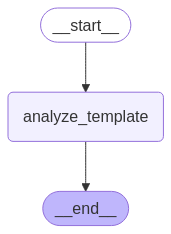

In [31]:
app = graph.compile()


display(Image(app.get_graph().draw_mermaid_png()))


# Initialize state with HTML template
# state = AgentState(html_template=html_template)

In [32]:
# Start the workflow
task = app.invoke({'html_template':html_template}, {"recursion_limit": 10000})

**************************************************
{'html_template': '\n<!DOCTYPE html>\n<html>\n<head>\n    <title>{{company_name}} - Official Website</title>\n</head>\n<body>\n    <header>\n        <h1>Welcome to {{company_name}}</h1>\n        <p>{{company_tagline}}</p>\n    </header>\n\n    <section class="mission">\n        <h2>Our Mission</h2>\n        <p>{{company_mission}}</p>\n    </section>\n\n    <section class="services">\n        <h2>Our Services</h2>\n        <p>{{company_services}}</p>\n    </section>\n\n    <footer>\n        <p>Contact us at: {{company_email}}</p>\n    </footer>\n</body>\n</html>\n', 'messages': []}


In [33]:
for m in task['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Identified 5 fields to customize: company_name, company_tagline, company_mission, company_services, company_email


In [11]:
task

{'html_template': '\n<!DOCTYPE html>\n<html>\n<head>\n    <title>{{company_name}} - Official Website</title>\n</head>\n<body>\n    <header>\n        <h1>Welcome to {{company_name}}</h1>\n        <p>{{company_tagline}}</p>\n    </header>\n\n    <section class="mission">\n        <h2>Our Mission</h2>\n        <p>{{company_mission}}</p>\n    </section>\n\n    <section class="services">\n        <h2>Our Services</h2>\n        <p>{{company_services}}</p>\n    </section>\n\n    <footer>\n        <p>Contact us at: {{company_email}}</p>\n    </footer>\n</body>\n</html>\n',
 'data_fields': {'company_name': None,
  'company_tagline': None,
  'company_mission': None,
  'company_services': None,
  'company_email': None},
 'messages': [SystemMessage(content='Identified 5 fields to customize: company_name, company_tagline, company_mission, company_services, company_email', additional_kwargs={}, response_metadata={}, id='be9dc6a6-80c1-493f-9687-8457bd910a9a')]}

In [13]:
import json
import re

def clean_json_output(response):
    # Remove code block markers and extract JSON
    cleaned = re.sub(r"```json|```", "", response).strip()
    return json.loads(cleaned)

# Example usage
raw_response = """```json
{
  "company_name": "TechCorp",
  "company_tagline": "Innovating the Future",
  "company_mission": "To revolutionize technology.",
  "company_services": "AI Solutions, Cloud Computing",
  "company_email": "contact@techcorp.com"
}
```"""

json_data = clean_json_output(raw_response)
print(json_data)


{'company_name': 'TechCorp', 'company_tagline': 'Innovating the Future', 'company_mission': 'To revolutionize technology.', 'company_services': 'AI Solutions, Cloud Computing', 'company_email': 'contact@techcorp.com'}


In [ ]:
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>{{company_name}} - Official Website</title>
</head>
<body>
    <header>
        <h1>Welcome to {{company_name}}</h1>
        <p>{{company_tagline}}</p>
    </header>
    
    <section class="mission">
        <h2>Our Mission</h2>
        <p>{{company_mission}}</p>
    </section>
    
    <section class="services">
        <h2>Our Services</h2>
        <p>{{company_services}}</p>
    </section>
    
    <footer>
        <p>Contact us at: {{company_email}}</p>
    </footer>
</body>
</html>
"""